In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from networkx.utils import powerlaw_sequence, random_sequence
from networkx import configuration_model
import scipy
from scipy import optimize
from sympy.solvers import solve
from sympy import Symbol
from matplotlib import style
from scipy.interpolate import make_interp_spline, BSpline
import math
import copy
import pandas as pd
from networkx.algorithms.community import k_clique_communities
import itertools
from scipy import optimize



plt.style.use('ggplot')

In [2]:
"""scale-free network = la probabilità che un nodo abbia grado k è più o meno k^-lambda, lambda parametro"""

"""Name: { 
            generate_scale_free }
   Param: { 
            num_nodes = numero dei nodi sulla rete
            random_edge = numero di edge base che vengono aggiunti a ogni nodo
            prob_trinage = probabiltà oltre agli edge di base di aggiungere un triangolo al nodo
            seed = seed per avere sempre la stessa rete }
   Return: {
            lambda = calcolato sulla base di una media
            graph = il network generato con la power law
            list_deg = lista dei gradi dei nodi in ordine sequenziale }
   """
def generate_scale_free(num_nodes, random_edge, prob_triangle , seed, trueNetwork = False):
    
    if (trueNetwork == False):
        if prob_triangle < 0:
            graph = nx.barabasi_albert_graph(num_nodes, random_edge)
        else:    
            graph = nx.powerlaw_cluster_graph(num_nodes, random_edge, prob_triangle, seed) #Holme and Kim 
        # algorithm
        
    else: 
        graph = trueNetwork
        
    node_degree = list(graph.degree()) #list (node, degree)
    lamda_v = []
    current_edges = 0
    list_deg = []

    for node, degree in node_degree:
        list_deg.append(degree)
    
    mean = scipy.stats.moment(list_deg)
    second_momentum = scipy.stats.moment(list_deg, 2)

    counts = np.bincount(list_deg) #count number of occurrences of each value in array of non-negative ints
    mask = (counts > 0)
    
    '''
    #P(k) = x ^ - lambda
    #log(P(k)) = - lambda * log(x)
    #-lambda = log(P(k)) / log(x)
    #theta_lambda = sum(y_v) / len(lamda_v)
    '''
    #Code for this calculation
    for i in range(0, len(list_deg)):
        for j in range(0, len(counts)):
            if (j == list_deg[i]):
                if (counts[j] > 0):
                    lamda_v.append(np.log(counts[j]) / list_deg[i])
                else:
                    print("wrong")
    lamb = sum(lamda_v) / len(lamda_v)
    print("Analytical Lambda: ", lamb)
    
    x = np.arange(len(counts))[mask]
    y = counts[mask] / counts.sum()
    popt, pcov = optimize.curve_fit(power_law, x, y, bounds=([2.00001, 0], [10, 5]))
    print("fitted lambda: ", popt)

    parameters = graph_parameters(graph)
    parameters["lamb"] = popt[0]
    parameters["a"] = popt[1]

    return (graph, popt[0], parameters)

def power_law(x, lamb, a):
    return a * x ** (-lamb)

    
def draw_scale_free_distribution(network, lamb, parameters):
    num_nodes = len(network)
    node_degree = list(network.degree())  # list (node, degree)
    list_deg = []

    for node, degree in node_degree:
        list_deg.append(degree)
    
    mean = scipy.stats.moment(list_deg)
    second_momentum = scipy.stats.moment(list_deg, 2)

    counts = np.bincount(list_deg)
    mask = (counts > 0)

    plt.plot(np.arange(len(counts))[
             mask], counts[mask] / counts.sum(), "o", label="Network distribution")
    x = np.arange(1, len(counts))
    plt.plot(x,  power_law(
        x, lamb, parameters["a"]), label="Power Law")
    plt.xlabel(r"Degree $k$")
    plt.xscale("log")
    plt.ylabel(r"Probability $P(k)$")
    plt.yscale("log")
    plt.title(r"$N = {0:d}, \quad \lambda = {1:.2f}$".format(num_nodes, lamb))
    plt.legend(loc="best")
    plt.show()


'''create a random network whose degrees follow a poisson distribuition'''
def generate_random_network_poisson(num_nodes, p):
   
    network = nx.erdos_renyi_graph(num_nodes, p) #Returns a Gn,p random graph
    
    list_deg = []
    
    for node, degree in list(network.degree()):
        list_deg.append(degree)
    #print(list_deg)
    counts = np.bincount(list_deg) #Count number of occurrences of each value
    
    parameters = graph_parameters(network)
    #for large X_n the mean of X_n = lamb
    #lamb = sum(counts) / len(counts)
    lamb = sum(list_deg) / len(network.nodes)
    second_momentum = (lamb, lamb + lamb**2)
    parameters["lamb"]= lamb
    parameters["second_moment"] = second_momentum

    return (network, lamb, parameters)

def draw_scale_poisson_distribution(network):

    list_deg = []

    for node, degree in list(network.degree()):
        list_deg.append(degree)

    #print(list_deg)
    counts = np.bincount(list_deg) #Count number of occurrences of each value
    mask = (counts > 0)
    plt.plot(np.arange(len(counts))[mask], counts[mask] / counts.sum(), "o", label="Poisson")
    x = np.arange(1, len(counts))
    lamb = sum(list_deg) / len(network.nodes)
    
    #plt.plot(x, poisson)
    plt.xlabel(r"Degree $k$")
    plt.xscale("log")
    plt.ylabel(r"Probability $P(k)$")
    plt.yscale("log")
    plt.title(r"$N = {0:d}, \quad \lambda = {1:.2f}$".format(len(network), lamb))
    plt.legend(loc="best")
    plt.show() 

'''remove one node at random'''
def random_node_removal(network):
    
    lenght_of_list = len(network.nodes)
    value = random.randint(0, lenght_of_list-1)
    nodes = list(network.nodes)
    network.remove_node(nodes[value])
    
    return network

"""rimuovi una percentuale di nodi sul totale della rete"""

def loop_node_removal(network, percentage):

    network_removed = copy.deepcopy(network)
    
    per = round(percentage * len(network_removed.nodes))
    f = []
    P_0 = len(max(nx.connected_components(network_removed), key=len))
    P_inf_devided_P_0 = []
    #probabilità che un nodo all'"epoca" f appartenga al larger component
    # 

    for i in range(0, per):
        network_removed = random_node_removal(network_removed)
        f.append(i)
        if(len(list(nx.connected_components(network_removed)))==0):
            P_inf_devided_P_0.append(0)
            break
        P_inf_devided_P_0.append(
            len(max(nx.connected_components(network_removed))) / P_0)
    
    print(f'Eliminated nodes = {per}')
    print(
        f'Number of connected component = {nx.number_connected_components(network_removed)}')

    return (network_removed, P_inf_devided_P_0, f)


"""Rimuovi il nodo con maggior degree"""

def hub_node_removal(network):
    sorted_nodes = list(sorted(network.degree, key=lambda x: x[1], reverse=True))
    node_to_remove = sorted_nodes[0][0]
    network.remove_node(node_to_remove)    
    return network

"""rimuovi una percentuale di hub sul totale della rete"""

def loop_hub_removal(network, percentage):

    network_removed = copy.deepcopy(network)
    per = round(percentage * len(network_removed.nodes))
    f = []
    P_0 = len(max(nx.connected_components(network_removed), key=len))
    P_inf_devided_P_0 = []
    #probabilità che un nodo all'"epoca" f appartenga al larger component
    # 

    for i in range(0, per):
        network_removed = hub_node_removal(network_removed)
        f.append(i)
        if(len(list(nx.connected_components(network_removed)))==0):
            P_inf_devided_P_0.append(0)
            break
        P_inf_devided_P_0.append(
            len(max(nx.connected_components(network_removed))) / P_0)
    
    print(f'Eliminated hubs = {per}')
    print(
        f'Number of connected component = {nx.number_connected_components(network_removed)}')

    return (network_removed, P_inf_devided_P_0, f)

"""per calcolare il parametro fc, threshold critico"""

def compute_fc_power_law(network, lamb):
    
    list_deg = []

    for node, degree in list(network.degree()):
        list_deg.append(degree)

    if (lamb > 3):
        den_1 =  (lamb - 2) / (lamb - 3)
        den = (den_1 * min(list_deg)) - 1
        return 1 - (1 / den)
    else:
        den_1 = (lamb - 2) / ( 3 - lamb )
        den_2 = min(list_deg) ** (lamb - 2)
        den_3 = max(list_deg) ** (3 - lamb)
        den = (den_1 * den_2 * den_3) - 1
        return 1 - (1 / den)

"""per calcolare il parametro fc under attacks, threshold critico"""

def compute_fc_under_attack(network, lamb):
    sorted_nodes = list(sorted(network.degree, key=lambda x: x[1], reverse=False))
    k_min = sorted_nodes[0][1]
    #x = Symbol('x') 
    #solve(2 + ((2-lamb)/(3-lamb))*k_min*(x**((3-lamb)/(1-lamb))-1)-(x**((2-lamb)/(1-lamb))), x)
    f = lambda x: 2 + ((2-lamb)/(3-lamb))*k_min*(x**((3-lamb)/(1-lamb))-1)-(x**((2-lamb)/(1-lamb)))
    x = np.linspace(0,1,1000)
    return(optimize.fsolve(f,0.14))


def compute_fc_poisson(network_poisson, lamb):
    # 1 - 1 / (E[K^2]/E[K] - 1)
    #E[K] = lamb
    return 1- (1 / lamb) 

'''plot ratio against f'''
def robustness_plot(network, P_inf_devided_P_0, f):
    xnew = np.linspace(min(f), max(f), 200) 

    #define spline with degree k=7
    spl = make_interp_spline(f, P_inf_devided_P_0, k=7)
    y_smooth = spl(xnew)
    plt.plot(f, P_inf_devided_P_0, linewidth=4)
    #plt.plot([0.05] * len(f), P_inf_devided_P_0)
    plt.ylabel(r"Probability $P(f)/P(0)$")
    plt.xlabel(r"f")
    plt.show()


def draw_network(network, size = 2):
    fig = plt.figure(figsize=(20, 10))
    node_color = [float(network.degree(v)) for v in network]
    node_weigth = [float(network.degree(v) ** size) for v in network]
    nx.draw(network,
            node_size = node_weigth,
            pos = nx.spring_layout(network, (1 / len(network) ** (1/5))),
            node_color=node_color,
            width = 0.1,
            with_labels=False)
    

def graph_parameters(network, lamb = None):
    #for random graphs
    beta = 1
    lamb_p = 1
    nu = 1/2
    tau = 5/2
    if lamb == None:
        return {"beta": beta, "gamma_p": lamb_p, "nu": nu, "tau": tau}
    #for scale-free graphs
    if 2<=lamb<3:            
        beta = 1/(3-lamb)
        lamb_p = -1
        nu = (3-lamb)/(lamb-2)
        tau = (2*lamb-3)/(lamb-2)
    elif 3<=lamb<4:          
        beta = 1/(lamb-3)
        nu = (lamb-3)/(lamb-2)
        tau = (2*lamb-3)/(lamb-2)
    return {"beta":beta,"gamma_p":lamb_p, "nu":nu,"tau":tau}

def load_topology_network():
    df1 = pd.read_csv('out.topology.txt',  sep= ' ', header = None)
    topology_of_internet = nx.Graph()
    for i in range(len(df1)):
        node=df1.loc[i,:][0] 
        next_node=df1.loc[i,:][1]  
        topology_of_internet.add_edges_from([(node,next_node)])
    return topology_of_internet

def load_protein_network():    
    df = pd.read_csv('Protein-Interaction.txt',  sep= '\s+', header = None)
    protein_protein = nx.Graph()
    for i in range(len(df)):
        node=df.loc[i,:][0] 
        next_node=df.loc[i,:][1]  
        protein_protein.add_edges_from([(node,next_node)])
    return protein_protein


Create Powerlay Cluster netwokrs
Analytical Lambda:  5.4240920463027
fitted lambda:  [2.06878646 0.66410647]


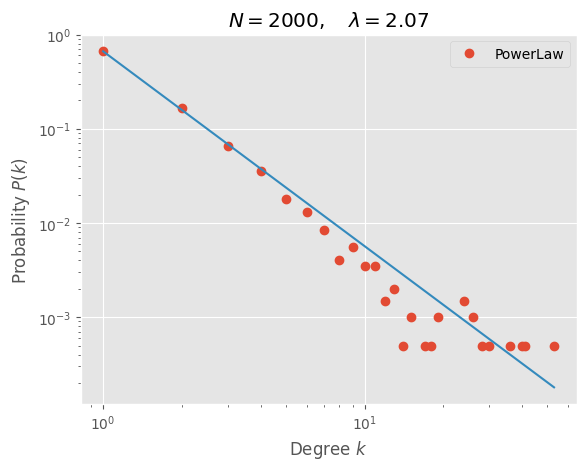

Analytical Lambda:  2.402309248937884
fitted lambda:  [2.39527255 2.69087174]


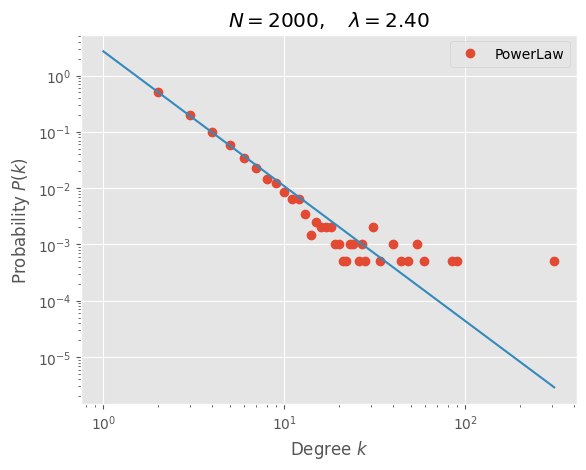

Analytical Lambda:  1.4613464668758114
fitted lambda:  [2.32051715 5.        ]


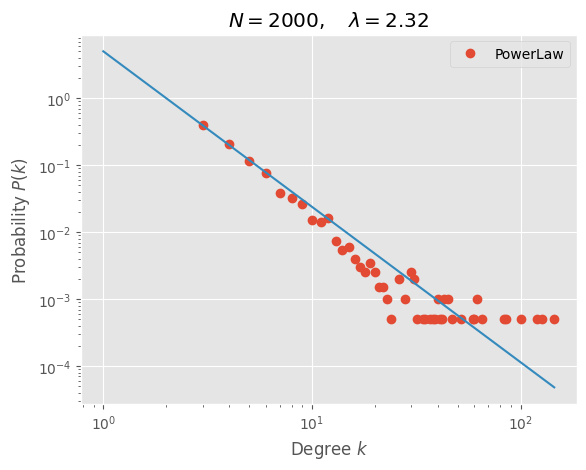

Crate BA networks
Analytical Lambda:  5.464384715263159
fitted lambda:  [2.08919418 0.66985714]


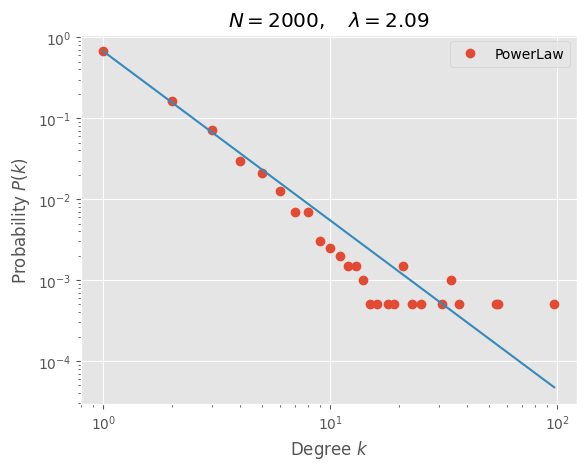

Analytical Lambda:  2.3704809132056535
fitted lambda:  [2.36125071 2.58390415]


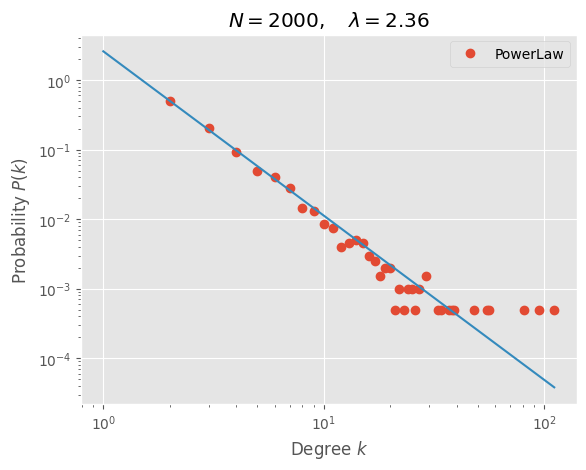

Analytical Lambda:  1.4474930866018156
fitted lambda:  [2.32732632 5.        ]


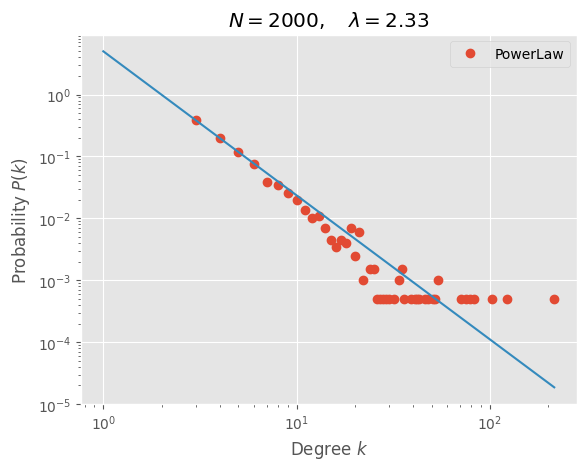

Use real networks
Analytical Lambda:  3.0791660299284165
fitted lambda:  [2.00001    0.44261907]


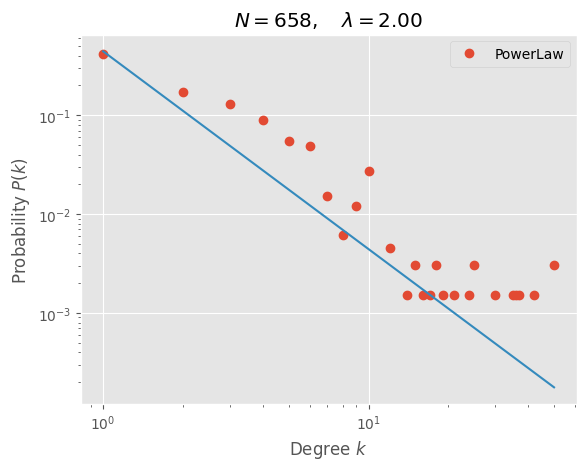

Analytical Lambda:  5.281146580138929
fitted lambda:  [2.00001   0.3977896]


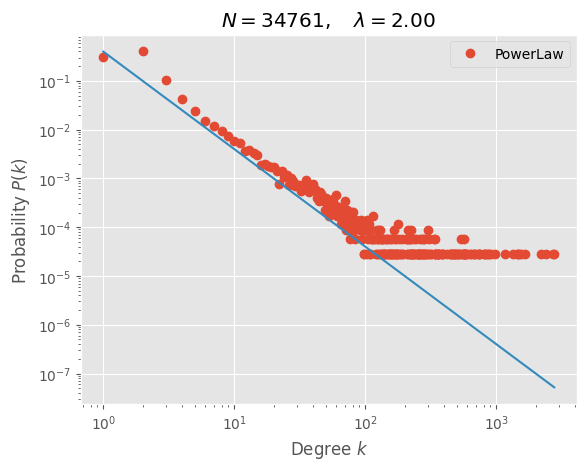

In [ ]:
seed = random.randint(0, 100000000000000000)

network_size = 2000
print("Create Powerlay Cluster netwokrs")
network_scale_free, lamb, params = generate_scale_free(
    network_size, 1, 0.9, seed)

draw_scale_free_distribution(network_scale_free, lamb, params)

network_scale_free, lamb, params = generate_scale_free(
    network_size, 2, 0.9, seed)

draw_scale_free_distribution(network_scale_free, lamb, params)

network_scale_free, lamb, params = generate_scale_free(
    network_size, 3, 0.9, seed)

draw_scale_free_distribution(network_scale_free, lamb, params)


print("Crate BA networks")

network_scale_free, lamb, params = generate_scale_free(
    network_size, 1, -1, seed)

draw_scale_free_distribution(network_scale_free, lamb, params)

network_scale_free, lamb, params = generate_scale_free(
    network_size, 2, -1, seed)

draw_scale_free_distribution(network_scale_free, lamb, params)

network_scale_free, lamb, params = generate_scale_free(
    network_size, 3, -1, seed)

draw_scale_free_distribution(network_scale_free, lamb, params)


print("Use real networks")
protein_graph = load_protein_network()
network_scale_free, lamb, params = generate_scale_free(
    network_size, 2, -1, seed, trueNetwork=protein_graph)

draw_scale_free_distribution(network_scale_free, lamb, params)


topology_graph = load_topology_network()
network_scale_free, lamb, params = generate_scale_free(
    network_size, 3, -1, seed, trueNetwork=topology_graph)

draw_scale_free_distribution(network_scale_free, lamb, params)


Artifical Scale Free Network
Create Network
Analytical Lambda:  2.421501344744198
fitted lambda:  [2.42503139 2.78071829]


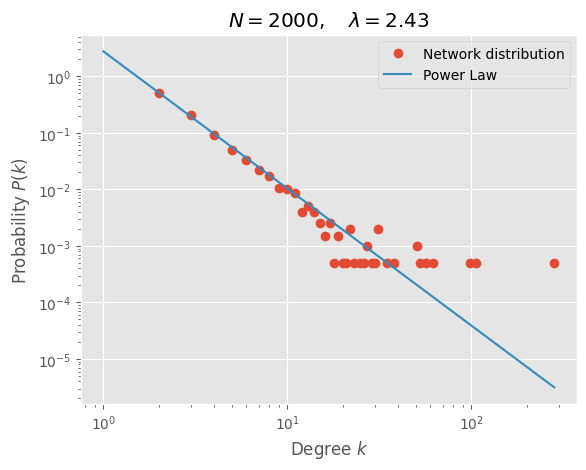

Simulate random failures, 99% nodes
Eliminated nodes = 1980
Number of connected component = 19
Compute robustness network


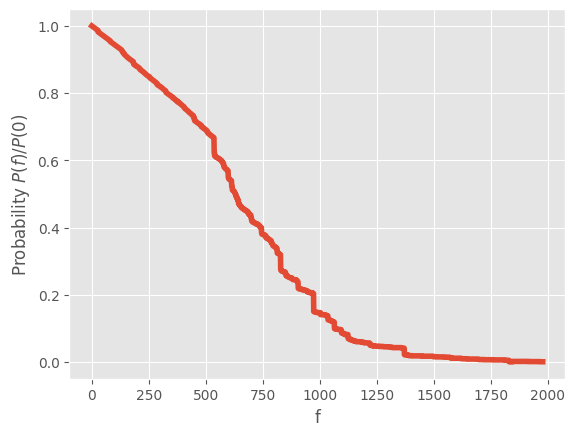

Compute Critical threshold
0.9591723371064141
Simulate attacks, 99% nodes
Eliminated hubs = 1980
Number of connected component = 20
Compute robustness network


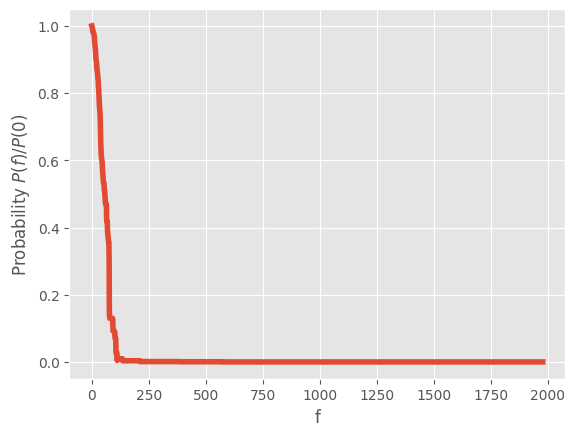

Compute Critical threshold
[0.19399408]
Draw Network


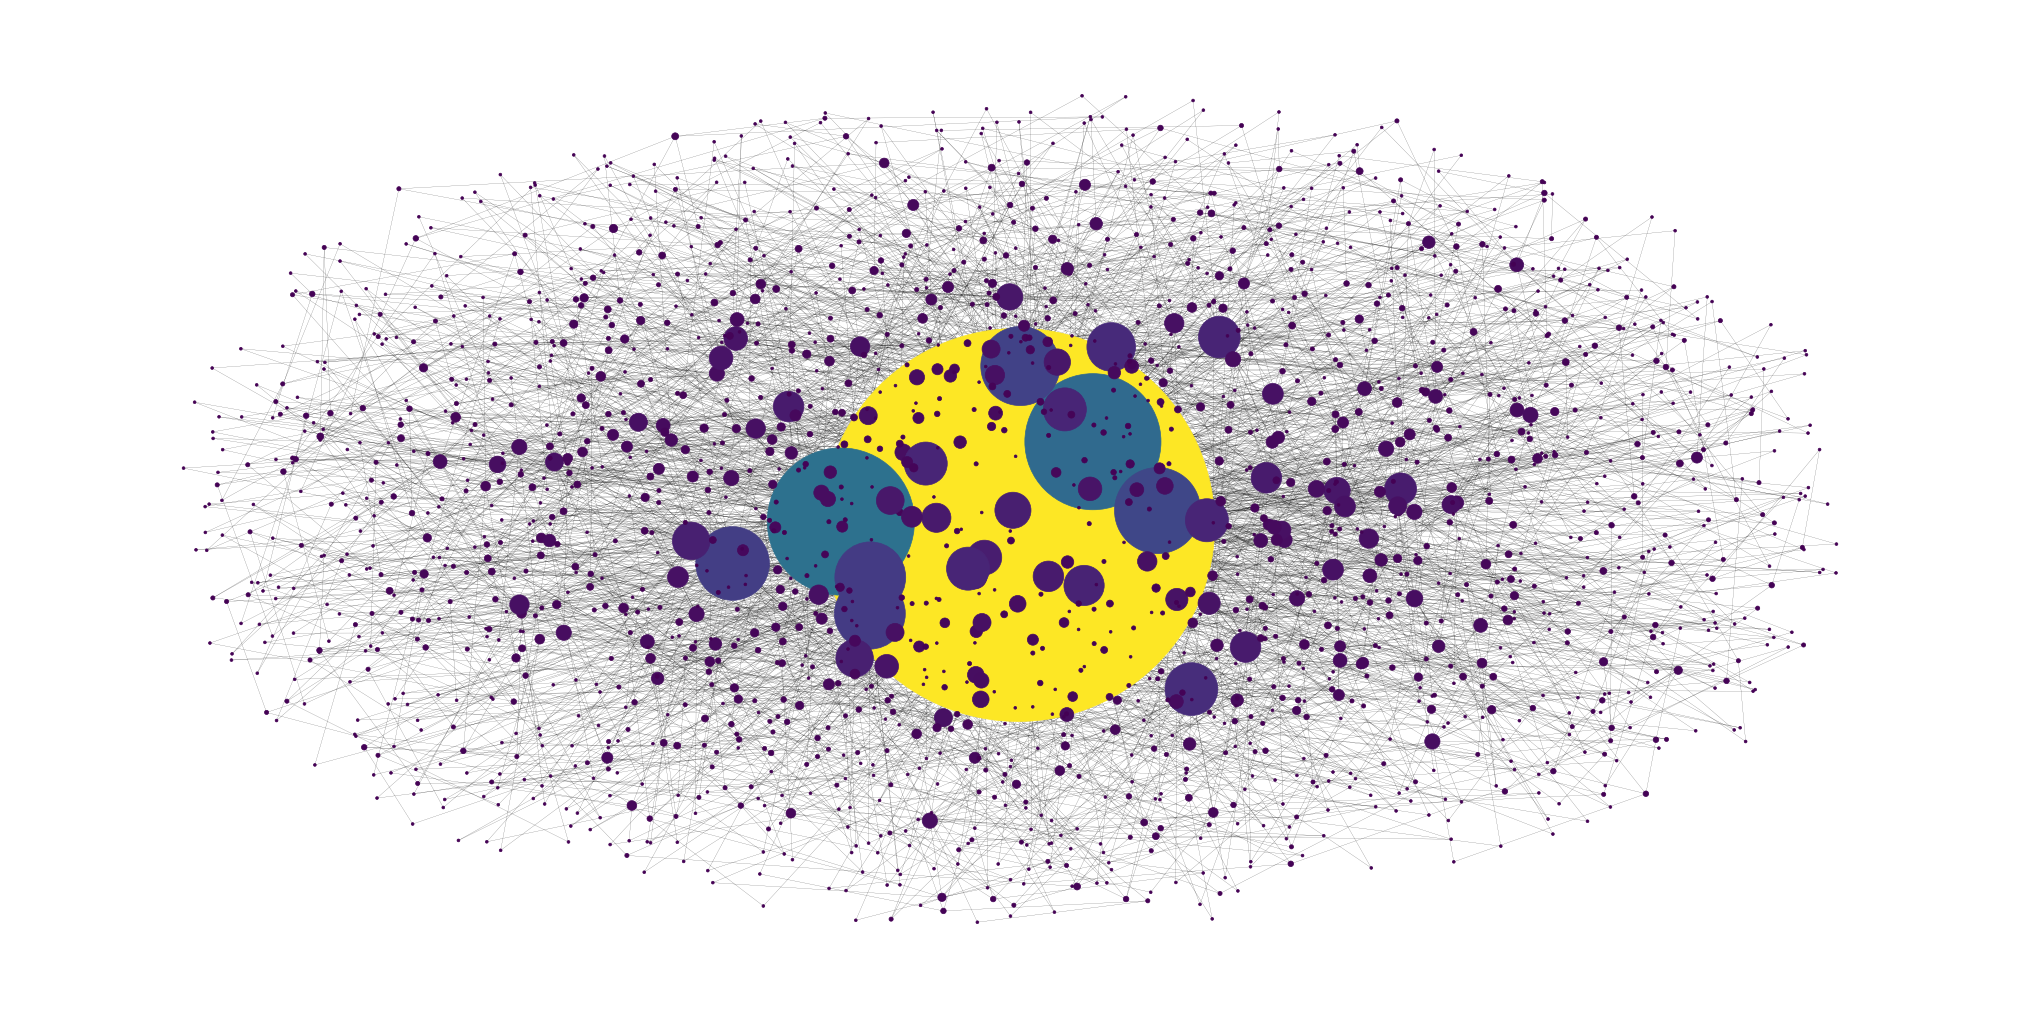

In [5]:
print("Artifical Scale Free Network")
seed = random.randint(0, 100000000000000000)
network_size = 2000

print("Create Network")
network_scale_free, lamb, params = generate_scale_free(
    network_size, 2, 0.9, seed)

draw_scale_free_distribution(network_scale_free, lamb, params)

#network_removed = percolation_one_node_random(network_scale_free)

print("Simulate random failures, 99% nodes")
network_removed, P_inf_devided_P_0, f = loop_node_removal(
    network_scale_free, 0.99)

print("Compute robustness network")
robustness_plot(network_scale_free, P_inf_devided_P_0, f)

print("Compute Critical threshold")
fc = compute_fc_power_law(network_scale_free, lamb)
print(fc)

print("Simulate attacks, 99% nodes")
network_removed, P_inf_devided_P_0, f = loop_hub_removal(
    network_scale_free, 0.99)

print("Compute robustness network")
robustness_plot(network_scale_free, P_inf_devided_P_0, f)

print("Compute Critical threshold")
fc = compute_fc_under_attack(network_scale_free, lamb)
print(fc)

print("Draw Network")
draw_network(network_scale_free)


Create Network
Analytical Lambda:  2.4202064121069964
fitted lambda:  [2.41924051 2.76559868]
Simulate random faliures, 99% nodes
Eliminated nodes = 1980
Number of connected component = 20
Compute Critical threshold
Create Network
Analytical Lambda:  2.412246725010824
fitted lambda:  [2.39377081 2.69859236]
Simulate random faliures, 99% nodes
Eliminated nodes = 1980
Number of connected component = 20
Compute Critical threshold
Create Network
Analytical Lambda:  2.409349675663187
fitted lambda:  [2.42955197 2.77777247]
Simulate random faliures, 99% nodes
Eliminated nodes = 1980
Number of connected component = 20
Compute Critical threshold
Create Network
Analytical Lambda:  2.4137583617220337
fitted lambda:  [2.36406521 2.6331431 ]
Simulate random faliures, 99% nodes
Eliminated nodes = 1980
Number of connected component = 20
Compute Critical threshold
Create Network
Analytical Lambda:  2.386196067997243
fitted lambda:  [2.32416843 2.51828434]
Simulate random faliures, 99% nodes
Eliminate

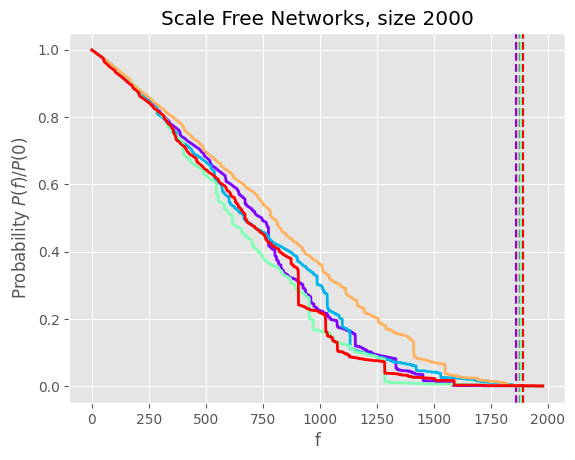

<Figure size 640x480 with 0 Axes>

Create Network
Analytical Lambda:  2.7485989364623915
fitted lambda:  [2.35919893 2.61421301]
Simulate random faliures, 99% nodes
Eliminated nodes = 4950
Number of connected component = 50
Compute Critical threshold
Create Network
Analytical Lambda:  2.7587670905953035
fitted lambda:  [2.45834766 2.85213352]
Simulate random faliures, 99% nodes
Eliminated nodes = 4950
Number of connected component = 49
Compute Critical threshold
Create Network
Analytical Lambda:  2.7476884378533555
fitted lambda:  [2.40141524 2.70861508]
Simulate random faliures, 99% nodes
Eliminated nodes = 4950
Number of connected component = 50
Compute Critical threshold
Create Network
Analytical Lambda:  2.7504117962287977
fitted lambda:  [2.40646369 2.72279858]
Simulate random faliures, 99% nodes
Eliminated nodes = 4950
Number of connected component = 50
Compute Critical threshold
Create Network
Analytical Lambda:  2.7622379421669763
fitted lambda:  [2.418839 2.762796]
Simulate random faliures, 99% nodes
Eliminated

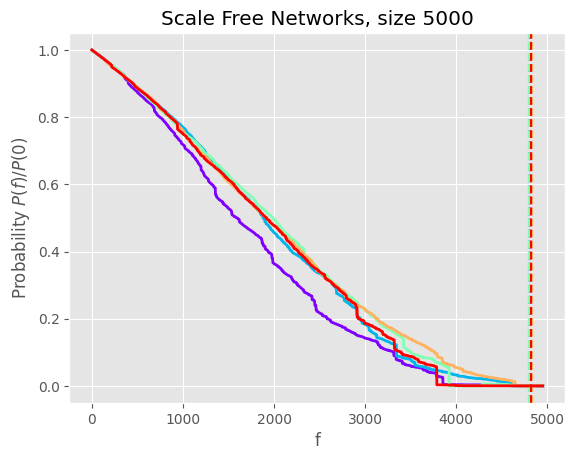

<Figure size 640x480 with 0 Axes>

Create Network
Analytical Lambda:  3.017381838734113
fitted lambda:  [2.41485098 2.74972928]
Simulate random faliures, 99% nodes
Eliminated nodes = 9900
Number of connected component = 98
Compute Critical threshold
Create Network
Analytical Lambda:  3.003590704571293
fitted lambda:  [2.36755605 2.63021742]
Simulate random faliures, 99% nodes
Eliminated nodes = 9900
Number of connected component = 98
Compute Critical threshold
Create Network
Analytical Lambda:  3.0161715739345465
fitted lambda:  [2.43660199 2.79895052]
Simulate random faliures, 99% nodes
Eliminated nodes = 9900
Number of connected component = 97
Compute Critical threshold
Create Network
Analytical Lambda:  3.0085641879303786
fitted lambda:  [2.40371472 2.7159099 ]
Simulate random faliures, 99% nodes
Eliminated nodes = 9900
Number of connected component = 99
Compute Critical threshold
Create Network
Analytical Lambda:  3.003954097304675
fitted lambda:  [2.39264162 2.68695874]
Simulate random faliures, 99% nodes
Eliminate

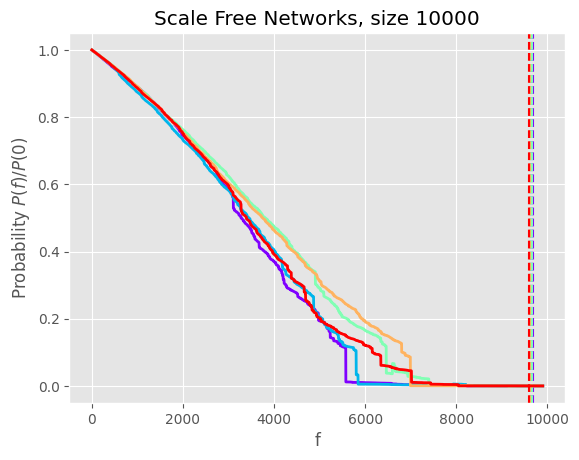

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
n_networks = 5
for size in [2000, 5000, 10000]:
    color = iter(plt.cm.rainbow(np.linspace(0, 1, n_networks)))

    for i in range(n_networks):
        seed = random.randint(0, 100000000000000000)
        print("Create Network")        
        network_scale_free, lamb, params = generate_scale_free(
            size, 2, 0.9, seed)
        #ratio["lamb"].append(lamb)
        #ratio["params"].append(params)

        print("Simulate random faliures, 99% nodes")
        network_removed, P_inf_devided_P_0, f = loop_node_removal(
            network_scale_free, 0.99)
        
        #ratio["P_inf"].append(P_inf_devided_P_0)

        print("Compute Critical threshold")
        fc = compute_fc_power_law(network_scale_free, lamb)
        #ratio["fc"].append(fc)
        #xnew = np.linspace(min(f), max(f), 200)

        #define spline with degree k=7
        #spl = make_interp_spline(f, P_inf_devided_P_0, k=7)
        #y_smooth = spl(xnew)
        label = f"{lamb:.4f}"
        c = next(color)

        plt.plot(f, P_inf_devided_P_0, linewidth=2, label = label, c = c)
        plt.axvline(x=max(f)*fc, linestyle='--', c = c)
    
    plt.ylabel(r"Probability $P(f)/P(0)$")
    plt.xlabel(r"f")
    plt.title(r"Scale Free Networks, size {0}".format(size))
    plt.figure(figsize=(8, 6), dpi=80)
    plt.show()
    plt.savefig("SF_"+str(size) + '.png')




Create Network
Analytical Lambda:  2.416252450142456
fitted lambda:  [2.39332357 2.70146316]
Simulate attacks, 99% nodes
Eliminated hubs = 1980
Number of connected component = 20
Compute Critical threshold
Create Network
Analytical Lambda:  2.410561921509104
fitted lambda:  [2.44770728 2.82149178]
Simulate attacks, 99% nodes
Eliminated hubs = 1980
Number of connected component = 20
Compute Critical threshold
Create Network
Analytical Lambda:  2.4222664052473557
fitted lambda:  [2.43685213 2.80937725]
Simulate attacks, 99% nodes
Eliminated hubs = 1980
Number of connected component = 20
Compute Critical threshold
Create Network
Analytical Lambda:  2.4188464471574966
fitted lambda:  [2.42832479 2.78503585]
Simulate attacks, 99% nodes
Eliminated hubs = 1980
Number of connected component = 20
Compute Critical threshold
Create Network
Analytical Lambda:  2.396104328586666
fitted lambda:  [2.3608909  2.60832183]
Simulate attacks, 99% nodes


KeyboardInterrupt: 

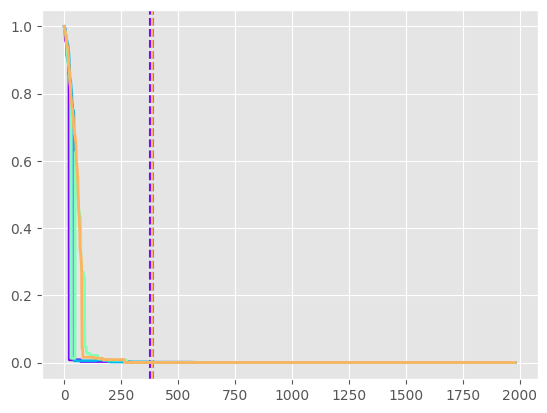

In [9]:
n_networks = 5
for size in [2000, 5000, 10000]:
    color = iter(plt.cm.rainbow(np.linspace(0, 1, n_networks)))

    for i in range(n_networks):
        seed = random.randint(0, 100000000000000000)
        print("Create Network")        
        network_scale_free, lamb, params = generate_scale_free(
            size, 2, 0.9, seed)


        print("Simulate attacks, 99% nodes")
        network_removed, P_inf_devided_P_0, f = loop_hub_removal(
            network_scale_free, 0.99)
        

        print("Compute Critical threshold")
        fc = compute_fc_under_attack(network_scale_free, lamb)
        c=next(color)

        plt.plot(f, P_inf_devided_P_0, linewidth=2, label=label, c = c)
        plt.axvline(x=max(f)*fc, linestyle='--', c=c)

    plt.ylabel(r"Probability $P(f)/P(0)$")
    plt.xlabel(r"f")
    plt.title(r"Scale Free Networks, size {0}".format(size))
    plt.figure(figsize=(8, 6), dpi=80)
    plt.show()


In [ ]:
print("Artificial Random Network")

print("Generate random network")
network_poisson, lamb, param = generate_random_network_poisson(3000, 0.1)
draw_scale_poisson_distribution(network_poisson)
print(lamb)
print("Random node faliure, 99%")
_, P_inf_devided_P_0, f = loop_node_removal(network_poisson, 0.99)

print("Compute Robustness network")
robustness_plot(network_poisson, P_inf_devided_P_0, f)

print("Compute Poisson fit")
f_c = compute_fc_poisson(network_poisson, lamb)
print(f_c)

print("Draw Network")
draw_network(network_poisson, size=1)

In [ ]:
"robustness for hub removal"

_, P_inf_devided_P_0, f = loop_hub_removal(network_poisson, 0.99)

print("Compute Robustness network")
robustness_plot(network_poisson, P_inf_devided_P_0, f)

In [ ]:
probs = [0.001, 0.003, 0.005, 0.01, 0.015, 0.02, 0.3]

for size in [3000, 7000]:
    color = iter(plt.cm.rainbow(np.linspace(0, 1, len(probs))))

    for p in probs:
        seed = random.randint(0, 100000000000000000)
        print("Create Network")        
        network_poisson, lamb, params = generate_random_network_poisson(size, p)
        print(lamb)
        print("Poisson distribution")

        print("Simulate random faliures, 99% nodes")
        network_removed, P_inf_devided_P_0, f = loop_node_removal(
            network_poisson, 0.99)
        

        print("Compute Critical threshold")
        fc = compute_fc_poisson(network_poisson, lamb)
        print(fc)


        c = next(color)
        plt.plot(f, P_inf_devided_P_0, linewidth=2, label = label, c = c)
        x = max(0, max(f)*fc)
        plt.axvline(x=x, linestyle='--', c = c)
    
    plt.ylabel(r"Probability $P(f)/P(0)$")
    plt.xlabel(r"f")
    plt.legend()
    plt.title(r"Ranom Networks, size {0}".format(size))

    plt.figure(figsize=(8, 6), dpi=80)
    plt.show()


In [ ]:
probs = [0.001, 0.003, 0.005, 0.01, 0.015, 0.02, 0.3]

for size in [3000, 7000]:
    color = iter(plt.cm.rainbow(np.linspace(0, 1, len(probs))))

    for p in probs:
        seed = random.randint(0, 100000000000000000)
        print("Create Network")
        network_poisson, lamb, params = generate_random_network_poisson(
            size, p)
        print(lamb)
        print("Poisson distribution")

        print("Simulate random faliures, 99% nodes")
        network_removed, P_inf_devided_P_0, f = loop_hub_removal(
            network_poisson, 0.99)

        print("Compute Critical threshold")
        fc = compute_fc_poisson(network_poisson, lamb)
        print(fc)

        c = next(color)
        plt.plot(f, P_inf_devided_P_0, linewidth=2, label=label, c=c)
        x = max(0, max(f)*fc)
        plt.axvline(x=x, linestyle='--', c=c)

    plt.ylabel(r"Probability $P(f)/P(0)$")
    plt.xlabel(r"f")
    plt.legend()
    plt.title(r"Ranom Networks, size {0}".format(size))

    plt.figure(figsize=(8, 6), dpi=80)
    plt.show()


Real Network
Create Network
Analytical Lambda:  3.0791660299284165
fitted lambda:  [2.00001    0.44261907]


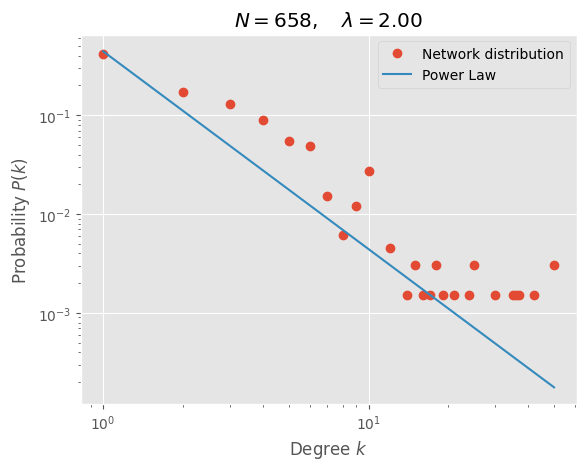

Compute Critical threshold
2.000500235550639
Simulate random failures, 99% nodes
Eliminated nodes = 651
Number of connected component = 7
Compute robustness network


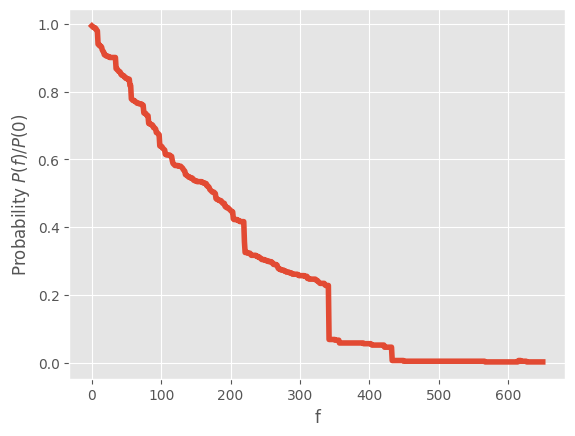

Compute targeted Failures
Eliminated hubs = 651
Number of connected component = 7
Show attack reisttance plot


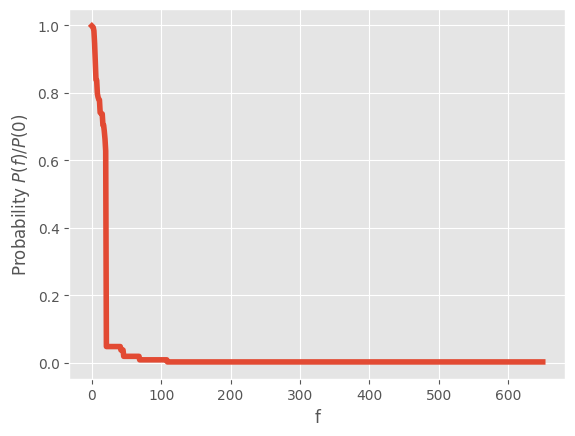

Draw Network


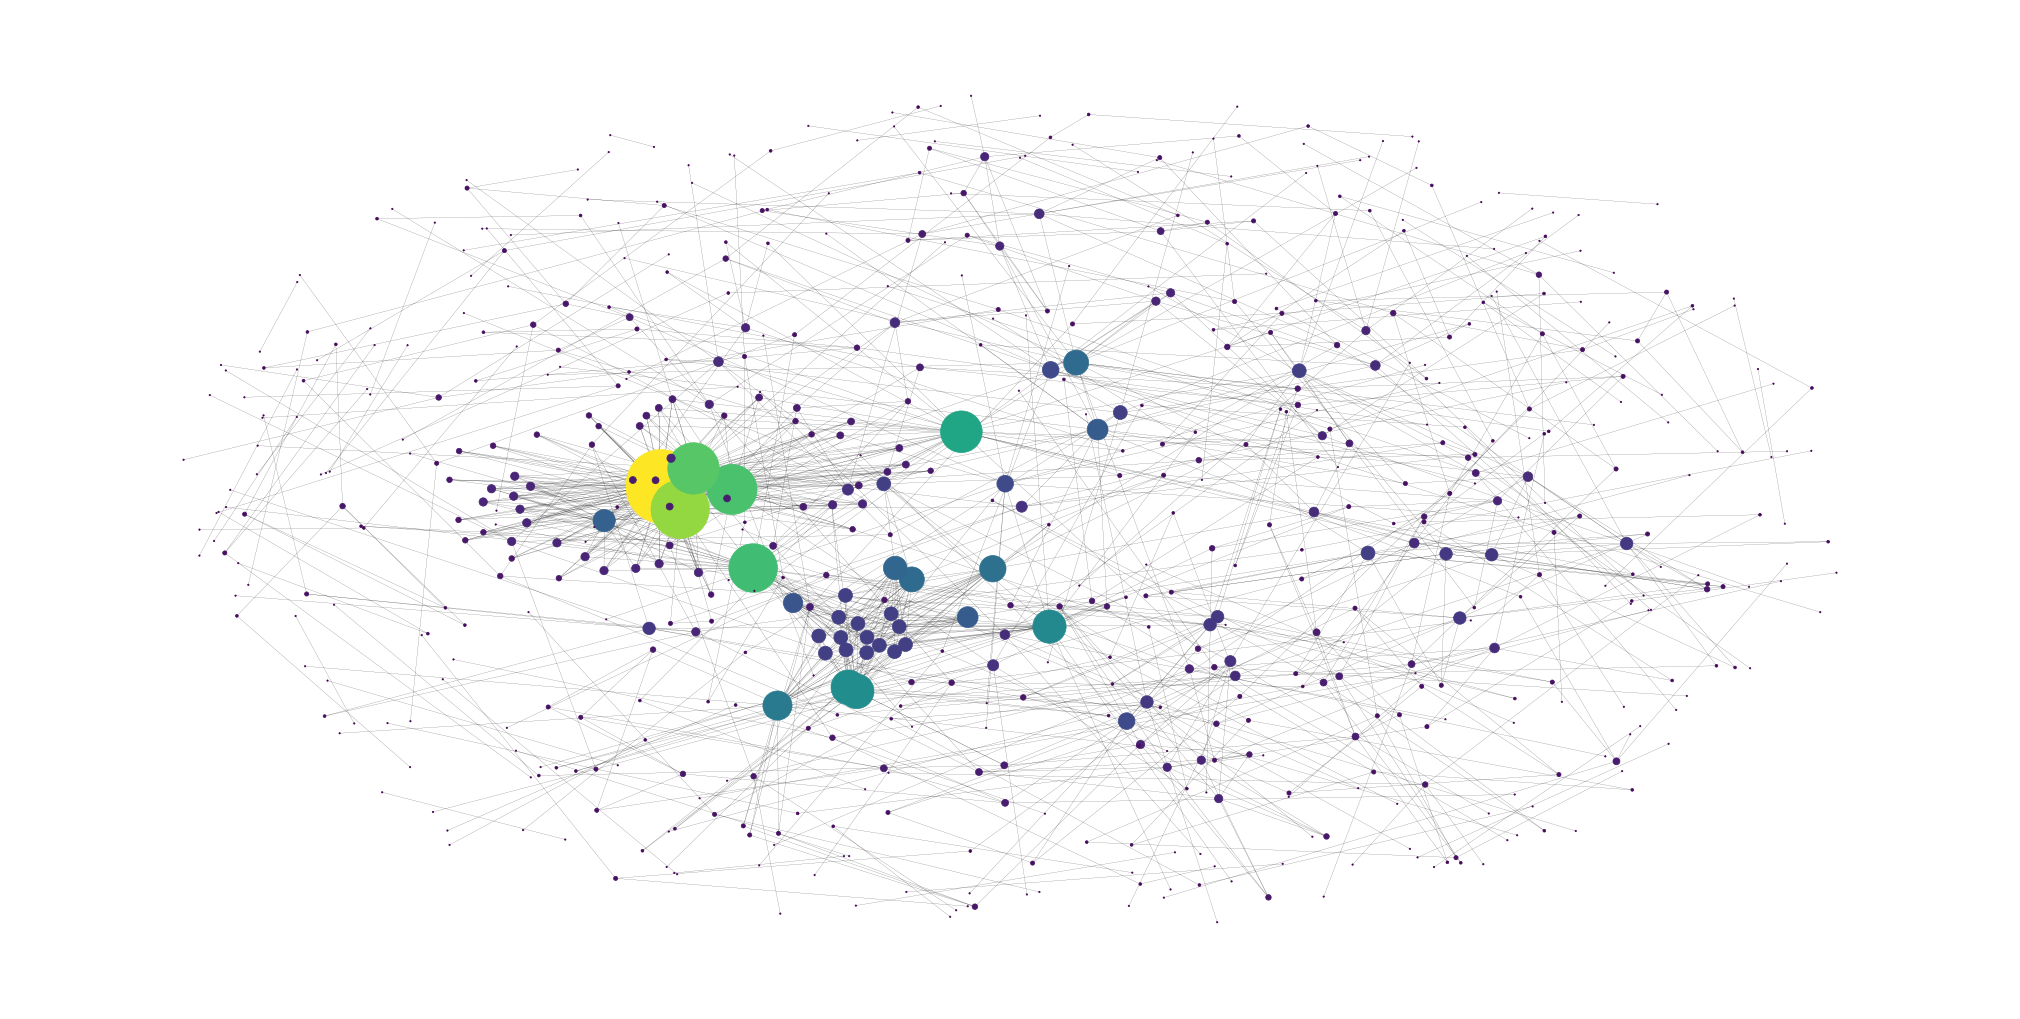

In [13]:
print("Real Network")
protein_protein = load_protein_network()
print("Create Network")
network_scale_free, lamb, params = generate_scale_free(network_size, 2, 0.9, seed, protein_protein)

draw_scale_free_distribution(network_scale_free, lamb, params)

print("Compute Critical threshold")
fc = compute_fc_power_law(network_scale_free, lamb)
print(fc)

print("Simulate random failures, 99% nodes")
network_removed, P_inf_devided_P_0, f = loop_node_removal(
    network_scale_free, 0.99)

print("Compute robustness network")
robustness_plot(network_scale_free, P_inf_devided_P_0, f)

print("Compute targeted Failures")
network_removed, P_inf_devided_P_0, f = loop_hub_removal(
    network_scale_free, 0.99)

print("Show attack reisttance plot")
robustness_plot(network_scale_free, P_inf_devided_P_0, f)


print("Draw Network")
draw_network(network_scale_free)

Real Network
Create Network
Analytical Lambda:  5.281146580138929
fitted lambda:  [2.00001   0.3977896]


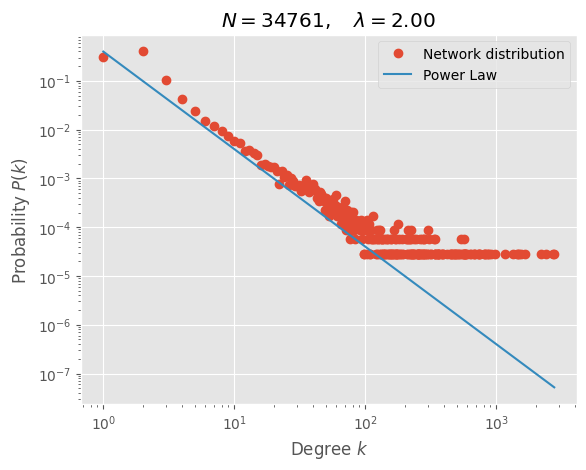

Compute Critical threshold
2.0283813606512116
Simulate random failures, 99% nodes


KeyboardInterrupt: 

In [5]:
print("Real Network")
topology_graph = load_topology_network()
print("Create Network")
network_scale_free, lamb, params = generate_scale_free(
    1, 2, 0.9, 1, topology_graph)

draw_scale_free_distribution(network_scale_free, lamb, params)

print("Compute Critical threshold")
fc = compute_fc_power_law(network_scale_free, lamb)
print(fc)

print("Simulate random failures, 99% nodes")
network_removed, P_inf_devided_P_0, f = loop_node_removal(
    network_scale_free, 0.99)

print("Compute robustness network")
robustness_plot(network_scale_free, P_inf_devided_P_0, f)

print("Compute targeted Failures")
network_removed, P_inf_devided_P_0, f = loop_hub_removal(
    network_scale_free, 0.99)

print("Shaow attack reisttance plot")
robustness_plot(network_scale_free, P_inf_devided_P_0, f)


print("Draw Network")
draw_network(network_scale_free)
